# CS178 Final Project
## IMDB Reviews dataset
### Students:
Rebecca Park : 50269810
Nick Hosun Song : 65482420

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , make_scorer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
## conda install libsvm
## conda install libsvm-python
from libsvm.svmutil import svm_train, svm_predict, svm_problem, svm_parameter , svm_read_problem


In [15]:
#Load the vocab from given data will correlate to bagofwords(feat) file
def load_vocab(vocab_file):
    with open(vocab_file, 'r',encoding ='utf-8') as file:
        vocab = file.read().splitlines()
    return {index: word for index, word in enumerate(vocab)}

vocab = load_vocab('imdb.vocab')
def convert_to_csr(data, num_features):
    row_ind = []
    col_ind = []
    data_values = []

    for i, row in enumerate(data):
        for feature_index, feature_value in row.items():
            row_ind.append(i)
            col_ind.append(feature_index)
            data_values.append(feature_value)

    return csr_matrix((data_values, (row_ind, col_ind)), shape=(len(data), num_features))

num_features = len(vocab)

y_train, X_train = svm_read_problem('train/labeledBow.feat')
y_test, X_test = svm_read_problem('test/labeledBow.feat')

X_train_csr = convert_to_csr(X_train,num_features)
X_test_csr = convert_to_csr(X_test,num_features)

#convert labels into binary format
#positive = 1 (7 , 8 , 9 , 10)
#negative = 0 (1, 2 , 3 , 4)
y_train_binary = [1 if y > 6 else 0 for y in y_train]
y_test_binary = [1 if y > 6 else 0 for y in y_test]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split( X_train_csr, y_train_binary, test_size=0.2, random_state=123)


## Sentiment Analysis
We are focusing on creating a sentiment analysis which is a natural language processing task that tries to determine 
the emotional tone of a piece of text which in our case is an IMDB movie review. We will be classifying our data into 
positive (1) and negative (0) labels. Our data was provided to us in a .feat format so all we had to do for data preprocessing
was convert the format into csr in order for us to be able to use Scikit_learn packages.

## Naive Bayes
The first model is Naive Bayes which assumes that all the features are independent of each other. Although we know that there are contextual relationships between words we use this as a baseline as Naive Bayes is a simple but somewhat effective model for text classification tasks.

In [16]:
# Assuming X_train_csr, y_train_binary, X_test_csr, y_test_binary are defined

# Initialize Naive Bayes model
model = MultinomialNB()

# Train the model using the training set
model.fit(X_train_csr, y_train_binary)

# Make predictions for both the training and test sets
y_pred_train = model.predict(X_train_csr)
y_pred_test = model.predict(X_test_csr)

# Calculate the error rate and F1 score for the training set
train_error_rate = 1 - accuracy_score(y_train_binary, y_pred_train)
train_f1_score = f1_score(y_train_binary, y_pred_train)

# Calculate the error rate and F1 score for the test set
test_error_rate = 1 - accuracy_score(y_test_binary, y_pred_test)
test_f1_score = f1_score(y_test_binary, y_pred_test)

# Print the results
print(f"Training Error Rate: {train_error_rate:.4f}")
print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Training Error Rate: 0.1000
Training F1 Score: 0.8962
Test Error Rate: 0.1864
Test F1 Score: 0.8010


## Linear SVM
The second type of model we chose was an SVM with a linear kernel. The linear kernel tends to work well when data is linearly separable in a feature space.
The hyperparameter that we chose to tune was the regularization strength parameter (C). We chose to use L2 regularization as it doesn't force feature selection as aggressively as L1 regularization. Tuning the reglarization is done in order to prevent overfitting and improve the generalization of the model. The strength parameter C encourages the model to have smaller weights/coefficients for each of the features, which will make the model less sensitive to the noise in the training data. This will help us control the margin between the decision boundary and the training points. In using a Linear SVM we are aiming to find the decision boundary that maximizes the margin between the classes while also correctly classifying the training examples. 

C = 1e-05
Validation Error Rate: 0.2356
Validation F1 Score: 0.7637
Test Error Rate: 0.2308
Test F1 Score: 0.7691

C = 0.0001
Validation Error Rate: 0.1446
Validation F1 Score: 0.8566
Test Error Rate: 0.1557
Test F1 Score: 0.8461

C = 0.001
Validation Error Rate: 0.1074
Validation F1 Score: 0.8926
Test Error Rate: 0.1203
Test F1 Score: 0.8804

C = 0.01
Validation Error Rate: 0.1052
Validation F1 Score: 0.8947
Test Error Rate: 0.1234
Test F1 Score: 0.8767

C = 0.1
Validation Error Rate: 0.1196
Validation F1 Score: 0.8796
Test Error Rate: 0.1419
Test F1 Score: 0.8571

C = 1
Validation Error Rate: 0.1278
Validation F1 Score: 0.8716
Test Error Rate: 0.1526
Test F1 Score: 0.8458



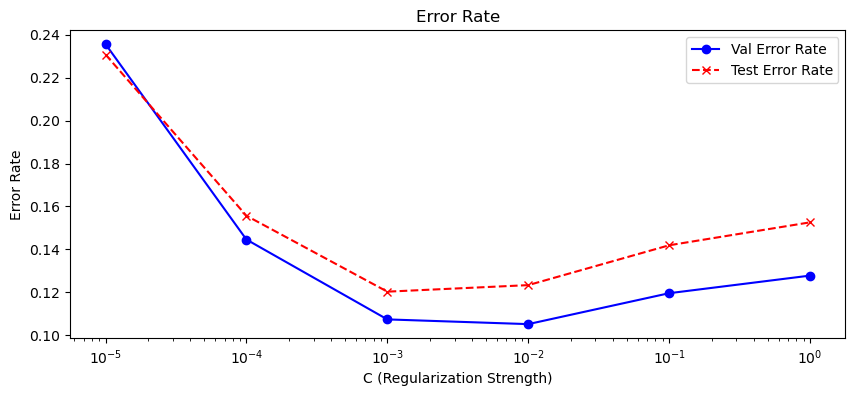

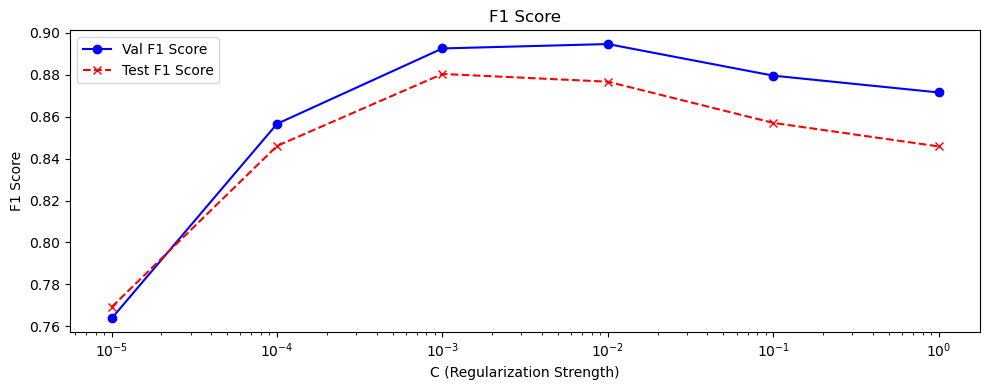

In [17]:
# Testing with linear kernel with different regularization strengths and cross-validation to test different metrics
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Dictionaries to store validation and test metrics
val_metrics_linear = {'error_rate': [], 'f1': []}
test_metrics_linear = {'error_rate': [], 'f1': []}

# Loop through and create a model for each regularization strength
for C in C_values:
    model = LinearSVC(C=C, dual=False, max_iter=5000)
    model.fit(X_train_split, y_train_split)

    # Validate the model
    y_pred_val = model.predict(X_val_split)
    val_metrics_linear['error_rate'].append(1 - accuracy_score(y_val_split, y_pred_val))
    val_metrics_linear['f1'].append(f1_score(y_val_split, y_pred_val))

    # Test the model
    y_pred_test = model.predict(X_test_csr)
    test_metrics_linear['error_rate'].append(1 - accuracy_score(y_test_binary, y_pred_test))
    test_metrics_linear['f1'].append(f1_score(y_test_binary, y_pred_test))

    # Print the results for each C value
    print(f"C = {C}")
    print(f"Validation Error Rate: {val_metrics_linear['error_rate'][-1]:.4f}")
    print(f"Validation F1 Score: {val_metrics_linear['f1'][-1]:.4f}")
    print(f"Test Error Rate: {test_metrics_linear['error_rate'][-1]:.4f}")
    print(f"Test F1 Score: {test_metrics_linear['f1'][-1]:.4f}")
    print()

def plot_metric(metric, title):
    plt.plot(C_values, val_metrics_linear[metric], marker='o', color='b', label='Val ' + title)
    plt.plot(C_values, test_metrics_linear[metric], linestyle='--', marker='x', color='r', label='Test ' + title)
    plt.xscale('log')
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()

# Plot the metrics for error rate and F1 score
plt.figure(figsize=(10, 4))
plot_metric('error_rate', 'Error Rate')

plt.figure(figsize=(10, 4))
plot_metric('f1', 'F1 Score')

plt.tight_layout()
plt.show()


## Analysis of Linear SVM tuning
In our analysis of the Linear SVM, after computing all of the linear models using the different Regularization strengths, we measure 4 different metrics.
- Error Rate : the proportion of misclassified instances
- Precision : proportion of models ability to correctly predict positive cases (minimize false positives)
- Recall : proportion of true positive predictions out of all the actual positive cases (minimize false negatives)
- F1 score: the mean between precision and recall finds the best model that captures the balance between minimizing both false positives and negatives.

From the graphs shown above, we can clearly tell that when using a Linear SVM a regularization strength of .001 gives us the best overall performance. If we were to focus only on the precision metric we cold arge that choosing to go with .01 would be better, but for our dataset we want a good balance of both false positives and negatives. So if we choose based off the error rate as well as the F1 score we can confidently say that choosing the Linear SVM model with a regularization strength of .001 is the best choice.


In [5]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
# implementing feedforward neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,SGD

#convert to dense array
X_train_dense = X_train_csr.toarray()
X_test_dense = X_test_csr.toarray() 
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)

#making sure we are using nparrays in order to pass through the neural network
# print(type(X_train_dense), X_train_dense.shape)
# print(type(X_test_dense), X_test_dense.shape)
# print(type(y_train_binary))
# print(type(y_test_binary))

#optimizer learning rate:
optimizer = Adam(learning_rate=.0001)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_features))
model.add(Dropout(0.5))  # dropout layer to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification

#will adjust the optimizer ~ SGD,adam,rmsprop,adamax,nadam,etc.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#will adjust epochs, batch_size, and validation_split to find the optimal range
history = model.fit(X_train_dense, y_train_binary, epochs=10, batch_size=32, validation_split=0.20)

loss, accuracy = model.evaluate(X_test_dense, y_test_binary)
error_rate = 1 - accuracy

print(f"Test Loss: {loss:.4f} , Test accuracy: {accuracy:.4f} , Test Error Rate: {error_rate:.4f}")


Epoch 1/10
625/625 [==============================] - 36s 54ms/step - loss: 0.6272 - accuracy: 0.6313 - val_loss: 0.7660 - val_accuracy: 0.5316
Epoch 2/10
625/625 [==============================] - 32s 52ms/step - loss: 0.4960 - accuracy: 0.7676 - val_loss: 0.6304 - val_accuracy: 0.7966
Epoch 3/10
625/625 [==============================] - 33s 53ms/step - loss: 0.3777 - accuracy: 0.8625 - val_loss: 0.5224 - val_accuracy: 0.8336
Epoch 4/10
625/625 [==============================] - 33s 52ms/step - loss: 0.2947 - accuracy: 0.9065 - val_loss: 0.5011 - val_accuracy: 0.8368
Epoch 5/10
625/625 [==============================] - 32s 52ms/step - loss: 0.2271 - accuracy: 0.9293 - val_loss: 0.4345 - val_accuracy: 0.8650
Epoch 6/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1840 - accuracy: 0.9452 - val_loss: 0.4184 - val_accuracy: 0.8642
Epoch 7/10
625/625 [==============================] - 32s 52ms/step - loss: 0.1414 - accuracy: 0.9608 - val_loss: 0.5731 - val_accuracy:

# Hyperparameters to adjust and test:
- optimizer - updates the weights of the neurons during training
- epochs - # of times we run through entire dataset forward and backwards
- batch_size - #of samples per update ~ takes the total amount of bags for training and divides by batchsize to show how much we are running per epoch
- validation_split : splits data into training data and test data, .2 = 20% saved for validation and does not get passed for training
  

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam

# Assuming X_train_csr and X_test_csr are your training and testing datasets
# Convert CSR matrices to dense arrays
X_train_dense = X_train_csr.toarray()
X_test_dense = X_test_csr.toarray()
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)

# Define the CNN model
model = Sequential()
# Conv1D layer with 64 filters, kernel size of 3
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train_dense.shape[1], 1)))
model.add(MaxPooling1D(2))  # Pooling to reduce dimensionality
model.add(Flatten())  # Flatten the output for the Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the data to add the channel dimension (required for Conv1D)
X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

# Train the model
history = model.fit(X_train_reshaped, y_train_binary, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_binary)
error_rate = 1 - accuracy

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Error Rate: {error_rate:.4f}")



Epoch 1/10
625/625 [==============================] - 520s 831ms/step - loss: 0.5967 - accuracy: 0.6921 - val_loss: 0.6494 - val_accuracy: 0.5976
Epoch 2/10
625/625 [==============================] - 518s 829ms/step - loss: 0.4097 - accuracy: 0.7925 - val_loss: 0.5251 - val_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 515s 824ms/step - loss: 0.3543 - accuracy: 0.8411 - val_loss: 0.6391 - val_accuracy: 0.7624
Epoch 4/10
625/625 [==============================] - 514s 823ms/step - loss: 0.3162 - accuracy: 0.8539 - val_loss: 0.7374 - val_accuracy: 0.7742
Epoch 5/10
625/625 [==============================] - 513s 820ms/step - loss: 0.2648 - accuracy: 0.8765 - val_loss: 0.6463 - val_accuracy: 0.8092
Epoch 6/10
625/625 [==============================] - 512s 819ms/step - loss: 0.2295 - accuracy: 0.8846 - val_loss: 1.1432 - val_accuracy: 0.7516
Epoch 7/10
625/625 [==============================] - 515s 825ms/step - loss: 0.2202 - accuracy: 0.8930 - val_loss: 0.9675 -